In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import gc
import glob
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.activations import elu, softmax
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import BatchNormalization, Activation
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
kaggleDir = '../input/driverdistractiondetection/driver-distraction-detection'
train_img_dir = 'drivers/train/'
test_img_dir = 'drivers/test/'
CLASSES = {"c0": "safe driving", "c1": "texting - right", "c2": "talking on the phone - right", "c3": "texting - left",
           "c4": "talking on the phone - left", "c5": "operating the radio", "c6": "drinking", "c7": "reaching behind",
           "c8": "hair and makeup", "c9": " talking to passenger"}
IMG_DIM = 299
CHANNEL_SIZE = 3
SEED_VAL = 41
BATCH_SIZE = 50
EPOCHS = 20  # Tootal Number of epoch

In [ ]:
img_rows = 224
img_cols = 224

In [ ]:
tf.random.set_seed(SEED_VAL)
gc.enable()
np.random.seed(SEED_VAL)
random.seed(SEED_VAL)

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Driver_Distraction_Detection/driver_imgs_list.csv', low_memory=True)
print('Number of Samples in trainset : {}'.format(df_train.shape[0]))
print('Number Of districted Classes : {}'.format(len((df_train.classname).unique())))

df_train = shuffle(df_train)

Number of Samples in trainset : 22424
Number Of districted Classes : 10


In [ ]:
print("[INFO] : Load all the images.....")
trainImgDir = os.path.join(kaggleDir, train_img_dir)
testImgDir = os.path.join(kaggleDir, test_img_dir)
trainImgs = glob.glob(trainImgDir + '*/*.jpg')
testImgs = glob.glob(testImgDir + '*.jpg')
len(trainImgs), len(testImgs)

[INFO] : Load all the images.....


(0, 0)

In [ ]:
for x in trainImgs:
    print(x)
    break

for x in testImgs:
    print(x)
    break

In [ ]:
# Display top five record in csv
df_train.head()

,subject,classname,img
15104,p050,c6,img_95325.jpg
13940,p049,c4,img_38128.jpg
3115,p015,c7,img_62528.jpg
599,p002,c7,img_39755.jpg
3875,p016,c5,img_69053.jpg


In [ ]:
# Dispaly Last five samples from CSV.
df_train.tail()

,subject,classname,img
8513,p026,c3,img_72027.jpg
21584,p075,c9,img_64627.jpg
20450,p072,c0,img_47528.jpg
931,p012,c2,img_85044.jpg
1984,p014,c4,img_23408.jpg


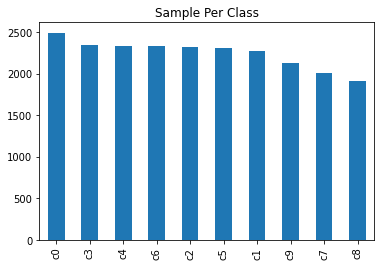

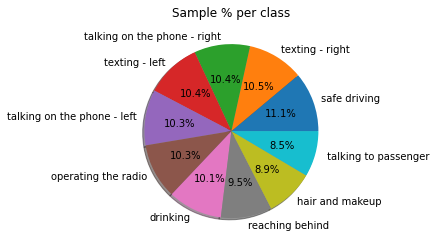

In [ ]:
class_freq_count = df_train.classname.value_counts()

class_freq_count.plot(kind='bar', label='index')
plt.title('Sample Per Class');
plt.show()

plt.pie(class_freq_count, autopct='%1.1f%%', shadow=True, labels=CLASSES.values())
plt.title('Sample % per class');
plt.show()

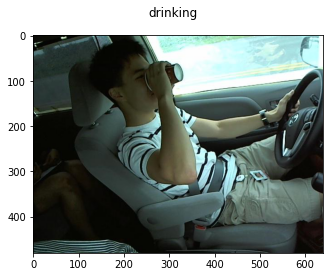

In [ ]:
imgPath = os.path.join("/content/drive/MyDrive/Driver_Distraction_Detection/train/c6/img_20716.jpg")
img = load_img(imgPath)
plt.suptitle(CLASSES['c6'])
plt.imshow(img)

In [ ]:
def draw_driver(imgs, df, classId='c0'):
    fig, axis = plt.subplots(2, 3, figsize=(20, 7))
    for idnx, (idx, row) in enumerate(imgs.iterrows()):
        imgPath = os.path.join("/content/drive/MyDrive/Driver_Distraction_Detection/train/c0/img_99971.jpg")
        row = idnx // 3
        col = idnx % 3 
        img = load_img(imgPath)
        #         img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        plt.imshow(img)
        axis[row, col].imshow(img)
    plt.suptitle(CLASSES[classId])
    plt.show()

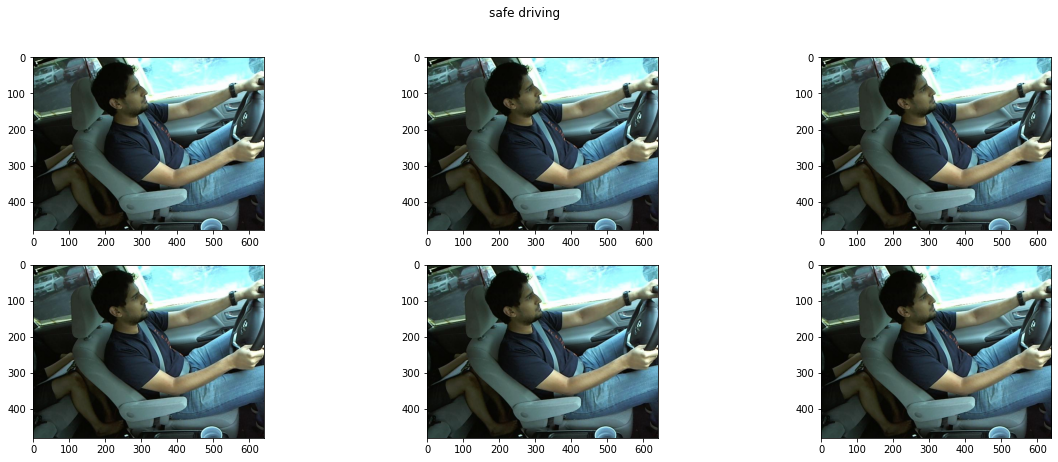

In [ ]:
draw_driver(df_train[df_train.classname == 'c0'].head(6), df_train, classId='c0')

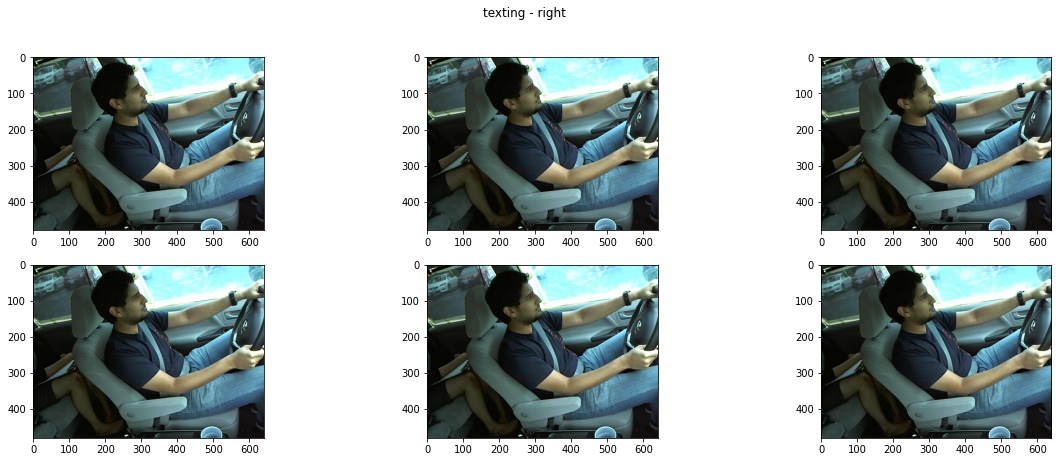

In [ ]:
draw_driver(df_train[df_train.classname == 'c1'].head(6), df_train, classId='c1')

In [ ]:
dfY = df_train.classname
x_train, x_test, y_train, y_test = train_test_split(df_train, dfY, test_size=0.15, stratify=dfY)
print('Number of Samples in XTrain : {} Ytrain: {}'.format(x_train.shape[0], y_train.shape[0]))
print('Number of Samples in Xtest : {} Ytest: {}'.format(x_test.shape[0], y_test.shape[0]))

Number of Samples in XTrain : 19060 Ytrain: 19060
Number of Samples in Xtest : 3364 Ytest: 3364


In [ ]:
df_train.head()

,subject,classname,img
15104,p050,c6,img_95325.jpg
13940,p049,c4,img_38128.jpg
3115,p015,c7,img_62528.jpg
599,p002,c7,img_39755.jpg
3875,p016,c5,img_69053.jpg


In [ ]:
df_train['file_name']=df_train.img.apply(lambda  x:x[:-4])

In [ ]:
df_train.head()

,subject,classname,img,file_name
15104,p050,c6,img_95325.jpg,img_95325
13940,p049,c4,img_38128.jpg,img_38128
3115,p015,c7,img_62528.jpg,img_62528
599,p002,c7,img_39755.jpg,img_39755
3875,p016,c5,img_69053.jpg,img_69053


In [ ]:
class SimplePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        #         print("[INFO] : Simple PreProcessor invoked...!")
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        #         print("[INFO] : Prepossess Resizing invoked...!")
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

In [ ]:
class ImageToArrayPreprocessor:
    def __init__(self, dataFormat=None):
        self.dataFormat = dataFormat

    def preprocess(self, image):
        return img_to_array(image, data_format=self.dataFormat)

In [ ]:
class SimpleDataLoader:
    def __init__(self, preprocessors=None):
        self.preprocessors = preprocessors
        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, trainImgs, verbose=-1):
        imgData = []
        imgLabels = []
        for (idx, imgPath) in enumerate(trainImgs):
            tmpImg = cv2.imread(imgPath)
            classLabel = imgPath.split(os.path.sep)[-2]

            if self.preprocessors is not None:
                for preprocesor in self.preprocessors:
                    img = preprocesor.preprocess(tmpImg)
                    gc.collect()
                imgData.append(tmpImg)
                imgLabels.append(imgLabels)

            if verbose > 0 and idx > 0 and (idx + 1) % verbose == 0:
                print('[INFO]: Processed {}/{}'.format((idx + 1), len(trainImgs)))
        print(len(imgData), len(imgLabels))
        return np.array(imgData), np.array(imgLabels)

In [ ]:
print("[INFO] : Loading data from desk and scale the raw pixel intensities to the range [0,1] ....!")

[INFO] : Loading data from desk and scale the raw pixel intensities to the range [0,1] ....!


In [ ]:
mgPath = os.path.join(kaggleDir, train_img_dir, "c6/img_20687.jpg")
image=load_img(imgPath)
image=img_to_array(image)
image=np.expand_dims(image, axis=0)
generator = ImageDataGenerator(rotation_range=30,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               shear_range=0.2,
                               zoom_range=0.2,
#                                horizontal_flip=True,
                               fill_mode='nearest') 
imageGen=generator.flow(image,batch_size=1)

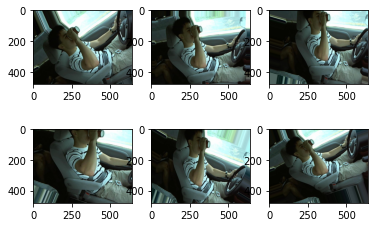

In [ ]:
for i in range(6):
    nextImg=imageGen.next()
    plt.subplot(230 + 1 + i)
    image = nextImg[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [ ]:
generator = ImageDataGenerator(rescale=1 / 255.0,
                               zoom_range=30,
                               samplewise_center=True,
                               height_shift_range=0.2,
                               width_shift_range=0.2,
                               shear_range=0.2, 
                               fill_mode='nearest',
                               validation_split=0.15)

In [ ]:
train_generator = generator.flow_from_directory(directory=os.path.join(kaggleDir, train_img_dir),
                                                classes=CLASSES.keys(),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                target_size=(IMG_DIM, IMG_DIM),
                                                shuffle=True,
                                                seed=SEED_VAL,
                                                subset='training')
valid_generator = generator.flow_from_directory(directory=os.path.join(kaggleDir, train_img_dir),
                                                classes=CLASSES.keys(),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                target_size=(IMG_DIM, IMG_DIM),
                                                shuffle=True,
                                                seed=SEED_VAL,
                                                subset='validation')
train_generator.class_indices
gc.collect()

Found 0 images belonging to 10 classes.
Found 0 images belonging to 10 classes.


45285

In [ ]:
train_generator.class_indices,valid_generator.samples

({'c0': 0,
  'c1': 1,
  'c2': 2,
  'c3': 3,
  'c4': 4,
  'c5': 5,
  'c6': 6,
  'c7': 7,
  'c8': 8,
  'c9': 9},
 0)

In [ ]:
trainImgs[:5]

[]

In [ ]:
earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=8, verbose=1, min_delta=0.0000001)
reduceRL = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.001, min_delta=0.0001, verbose=1,
                             min_lr=1e-6)
callbacks = [reduceRL]  # earlyStop

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=[IMG_DIM, IMG_DIM, 1], activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation=elu))
# model.add(Activation(activation=elu))
# model.add(MaxPooling2D())
# model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Dense(3000))
model.add(Activation(activation=elu))
model.add(Dropout(rate=0.25))
model.add(Dense(2000))
model.add(Activation(activation=elu))
model.add(Dropout(rate=0.25))
model.add(Dense(len(CLASSES)))
model.add(Activation(activation=softmax))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 297, 297, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 146, 146, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0

In [ ]:
# opt = SGD()#lr=0.0001
from keras.optimizers import Adam
opt=Adam()
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['acc'])

In [ ]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

In [ ]:
batch_size = 40
nb_epoch = 10

In [ ]:
!rm -f saved_models/weights_best_vanilla.hdf5

In [ ]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Driver_Distraction_Detection/driver_imgs_list.csv', low_memory=True)
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [ ]:
by_drivers = dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In [ ]:
from os.path import join
from glob import glob
NUMBER_CLASSES = 10
# Color type: 1 - grey, 3 - rgb

def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

# Training
def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('/content/drive/MyDrive/Driver_Distraction_Detection/train', 'c' + str(classed), '*.jpg'))
        print('Getting jpg')
        for file in files:
            
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=40)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('/content/drive/MyDrive/Driver_Distraction_Detection/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids 

In [ ]:
img_rows = 64
img_cols = 64
color_type = 1
# !pip install scikit-learn==0.19.1

In [ ]:
nx_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', nx_train.shape)
print(nx_train.shape[0], 'train samples')

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0
Getting jpg


 10%|█         | 1/10 [05:32<49:51, 332.42s/it]

Loading directory c1
Getting jpg


 20%|██        | 2/10 [10:54<43:54, 329.32s/it]

Loading directory c2
Getting jpg


 30%|███       | 3/10 [16:18<38:13, 327.58s/it]

Loading directory c3
Getting jpg


 40%|████      | 4/10 [21:36<32:29, 324.98s/it]

Loading directory c4
Getting jpg


 50%|█████     | 5/10 [26:53<26:52, 322.50s/it]

Loading directory c5
Getting jpg


 60%|██████    | 6/10 [32:18<21:33, 323.30s/it]

Loading directory c6
Getting jpg


 70%|███████   | 7/10 [37:28<15:57, 319.07s/it]

Loading directory c7
Getting jpg


 80%|████████  | 8/10 [43:02<10:47, 323.84s/it]

Loading directory c8
Getting jpg


 90%|█████████ | 9/10 [48:05<05:17, 317.33s/it]

Loading directory c9
Getting jpg


100%|██████████| 10/10 [53:15<00:00, 319.57s/it]

Data Loaded in 3195.682580471039 second
Train shape: (8000, 64, 64, 1)
8000 train samples


In [ ]:
nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

0it [00:00, ?it/s]

Test shape: (0, 64, 64, 1)
0 Test samples


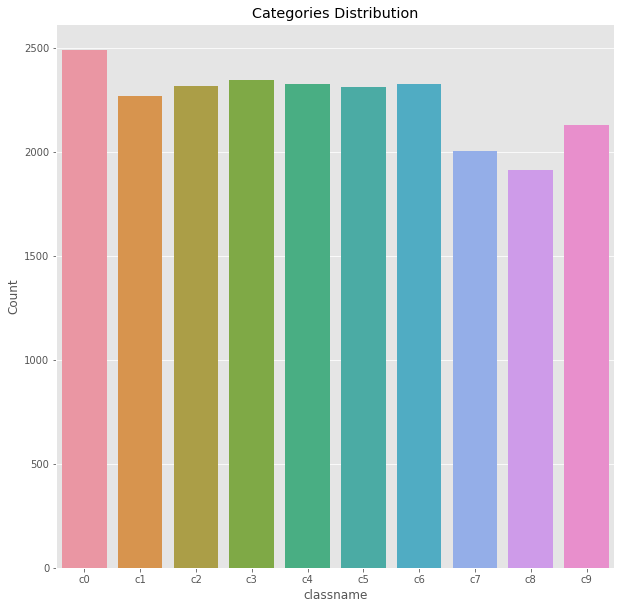

In [ ]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

In [ ]:
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id

,driver_id,Counts
0,p021,1237
1,p022,1233
2,p024,1226
3,p026,1196
4,p016,1078
5,p066,1034
6,p049,1011
7,p051,920
8,p014,876
9,p015,875


<Figure size 1440x1440 with 0 Axes>

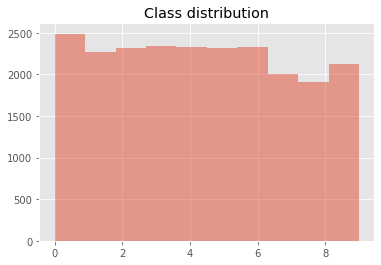

In [ ]:
# Plotting class distribution
dataset['class_type'] = dataset['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure(figsize = (20,20))
dataset.hist('class_type', alpha=0.5, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()

In [ ]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

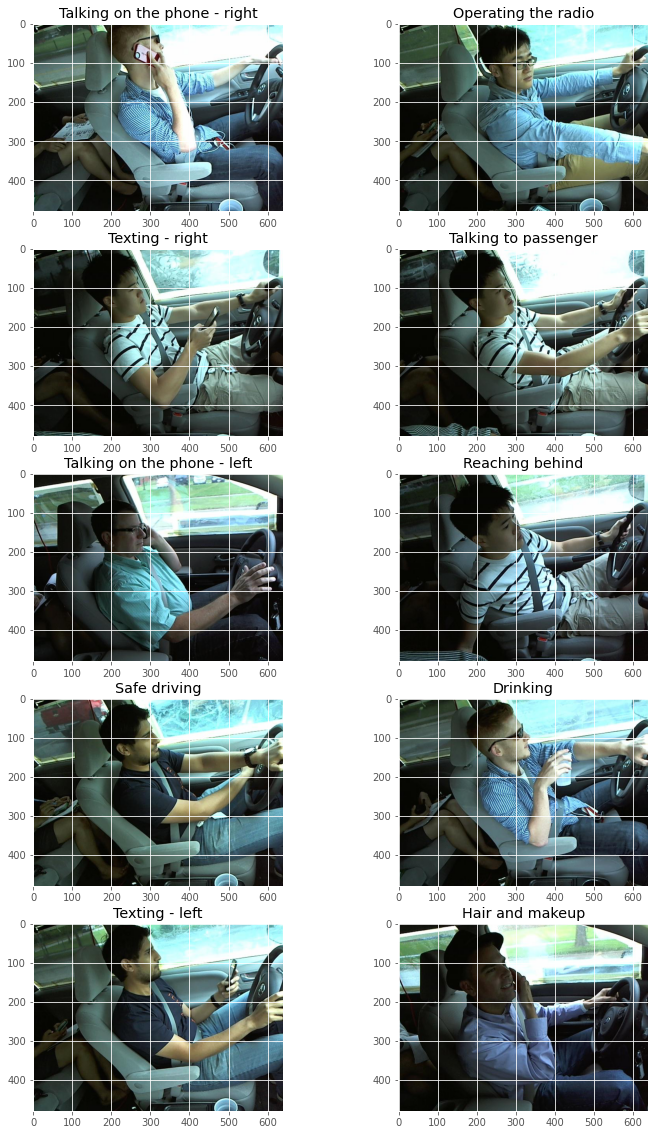

In [ ]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '/content/drive/MyDrive/Driver_Distraction_Detection/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [ ]:
def create_submission(predictions, test_id, info):
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
    
    now = datetime.datetime.now()
    
    if not os.path.isdir('kaggle_submissions'):
        os.mkdir('kaggle_submissions')

    suffix = "{}_{}".format(info,str(now.strftime("%Y-%m-%d-%H-%M")))
    sub_file = os.path.join('kaggle_submissions', 'submission_' + suffix + '.csv')
    
    result.to_csv(sub_file, index=False)
    
    return sub_file

# Create Vanilla Model

In [ ]:
batch_size = 40
nb_epoch = 10

In [ ]:
!rm -f saved_models/weights_best_vanilla.hdf5

In [ ]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]


Model V1

In [ ]:
def create_model_v1():
    # Vanilla CNN model
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 128, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 256, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 512, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'softmax'))
    
    return model

In [ ]:
model_v1 = create_model_v1()

# More details about the layers
model_v1.summary()

# Compiling the model
model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 512)        

In [ ]:
# Training the Vanilla Model version 1
history_v1 = model_v1.fit(nx_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

Epoch 1/10
200/200 [==============================] - 37s 20ms/step - loss: 10.9442 - accuracy: 0.2795 - val_loss: 0.4251 - val_accuracy: 0.8345

Epoch 00001: val_loss improved from inf to 0.42508, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 2/10
200/200 [==============================] - 4s 19ms/step - loss: 0.4437 - accuracy: 0.8572 - val_loss: 0.1217 - val_accuracy: 0.9705

Epoch 00002: val_loss improved from 0.42508 to 0.12168, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 3/10
200/200 [==============================] - 4s 19ms/step - loss: 0.2003 - accuracy: 0.9456 - val_loss: 0.0598 - val_accuracy: 0.9900

Epoch 00003: val_loss improved from 0.12168 to 0.05983, saving model to saved_models/weights_best_vanilla.hdf5
Epoch 4/10
200/200 [==============================] - 4s 19ms/step - loss: 0.1418 - accuracy: 0.9632 - val_loss: 0.0686 - val_accuracy: 0.9825

Epoch 00004: val_loss did not improve from 0.05983
Epoch 5/10
200/200 [======================

In [ ]:
model_v1.load_weights('saved_models/weights_best_vanilla.hdf5')

In [ ]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

In [ ]:
score = model_v1.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

63/63 [==============================] - 0s 6ms/step - loss: 0.0567 - accuracy: 0.9885
Score:  [0.056701887398958206, 0.9884999990463257]


In [ ]:
!rm -f saved_models/weights_best_vanilla.hdf5

In [ ]:

train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

In [ ]:
nb_train_samples = nx_train.shape[0]
nb_validation_samples = x_test.shape[0]
print(nb_train_samples)
print(nb_validation_samples)
training_generator = train_datagen.flow(nx_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

8000
2000


In [ ]:
checkpoint = ModelCheckpoint('saved_models/weights_best_vanilla.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v3 = model_v1.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         callbacks=[es, checkpoint],
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
200/200 [==============================] - 6s 27ms/step - loss: 1.6117 - accuracy: 0.4209 - val_loss: 0.2879 - val_accuracy: 0.9180
Epoch 2/5
200/200 [==============================] - 5s 25ms/step - loss: 0.6102 - accuracy: 0.7972 - val_loss: 0.1265 - val_accuracy: 0.9625
Epoch 3/5
200/200 [==============================] - 5s 26ms/step - loss: 0.3610 - accuracy: 0.8801 - val_loss: 0.0900 - val_accuracy: 0.9735
Epoch 4/5
200/200 [==============================] - 5s 26ms/step - loss: 0.2618 - accuracy: 0.9158 - val_loss: 0.0775 - val_accuracy: 0.9840
Epoch 5/5
200/200 [==============================] - 5s 26ms/step - loss: 0.2038 - accuracy: 0.9356 - val_loss: 0.0649 - val_accuracy: 0.9845


In [ ]:
# Evaluate the performance of the new model
score = model_v1.evaluate_generator(validation_generator, nb_validation_samples // batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.06494716554880142
Test Accuracy: 0.984499990940094


In [ ]:

def vgg_std16_model(img_rows, img_cols, color_type=3):
    nb_classes = 10
    # Remove fully connected layer and replace
    # with softmax for classifying 10 classes
    vgg16_model = VGG16(weights="imagenet", include_top=False)

    # Freeze all layers of the pre-trained model
    for layer in vgg16_model.layers:
        layer.trainable = False
        
    x = vgg16_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(nb_classes, activation = 'softmax')(x)

    model = Model(input = vgg16_model.input, output = predictions)
    
    return model